## installation

In [21]:
# imports
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from datetime import datetime, timedelta

## data collection

In [22]:
df = pd.read_csv("https://query.data.world/s/q475gmfce4fx47z2ggm3sp5b3gsz64?dws=00000")

In [23]:
df.head()

,season,date_code,weekending,region,Respiratory_Virus,Number_Positive,Specimens_Tested,Percent_Positive
0,2009-2010,200940,10/10/09,Bay Area,Influenza_A,36,220,16.36
1,2009-2010,200940,10/10/09,Bay Area,Influenza_B,0,220,0.00
2,2009-2010,200940,10/10/09,Bay Area,Total_Influenza,36,220,16.36
3,2009-2010,200940,10/10/09,Bay Area,RSV,0,190,0.00
4,2009-2010,200940,10/10/09,California,Influenza_A,1077,3324,32.40


In [24]:
# regions
unique_values = df["region"].unique()
print(unique_values)

['Bay Area' 'California' 'Central' 'Lower Southern' 'Northern'
 'Northern/Bay Area' 'Upper Southern' 'Upper/Lower Southern']


<Axes: >

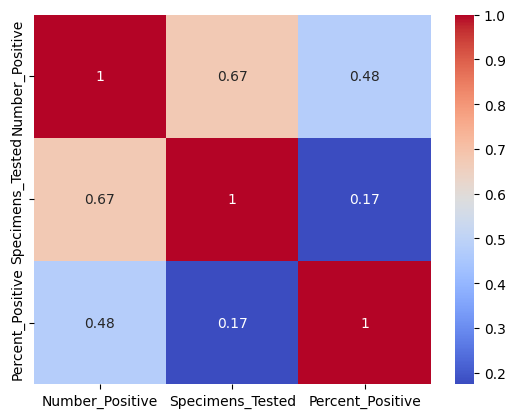

In [25]:
df["weekending"] = pd.to_datetime(df["weekending"], format="%m/%d/%y")

columns_for_correlation = ["Number_Positive", "Specimens_Tested", "Percent_Positive"]

subset_df = df[columns_for_correlation]

correlation_matrix = subset_df.corr()

sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")

## findings

- the region in question ['bay area' 'california' 'central' 'lower southern' 'northern'
 'northern/bay area' 'upper southern' 'upper/lower southern']
- using the heatmap, it can be deduced that the specimen_tested variable have a high correlation w/ the number_positive variable

In [26]:
# define threshold to determine yes/no outbreak, in this case i set if >= 100 then considered outbreak
df["Outbreak"] = df["Number_Positive"].apply(lambda x: 1 if x >= 100 else 0)

In [27]:
selected_columns = [
    "Respiratory_Virus",
    "Number_Positive",
    "Specimens_Tested",
    "Percent_Positive",
]

df.columns = df.columns.astype(str)

# one-hot encoding bc col Respiratory_Virus has multiple selections
enc = OneHotEncoder(sparse_output=False, drop=None)
respiratory_virus_encoded = pd.DataFrame(enc.fit_transform(df[["Respiratory_Virus"]]))

unique_viruses = df["Respiratory_Virus"].unique()

encoded_column_names = ["Respiratory_Virus_" + virus for virus in unique_viruses]

respiratory_virus_encoded.columns = encoded_column_names

missing_viruses = set(unique_viruses) - set(df["Respiratory_Virus"])
for virus in missing_viruses:
    respiratory_virus_encoded["Respiratory_Virus_" + virus] = 0

X = pd.concat([respiratory_virus_encoded, df[selected_columns[1:]]], axis=1)

y = df["Outbreak"]

# use mean to guess missing val in x
imputer = SimpleImputer(strategy="mean")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# split training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

model = LogisticRegression(max_iter=1000)

model.fit(X_train, y_train)

predictions = model.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 1.0


In [28]:
# set time to current date
current_date = datetime.now()

future_week = current_date + timedelta(weeks=1)

season = future_week.strftime("%Y-%Y")

data = {
    "season": [season] * 8,
    "date_code": [
        int(future_week.strftime("%Y%U"))] * 8,
    "weekending": [
        future_week.strftime("%Y-%m-%d")] * 8,
    "region": [
        'Bay Area', 'California', 'Central', 'Lower Southern', 'Northern',
        'Northern/Bay Area', 'Upper Southern', 'Upper/Lower Southern'
    ],
    "Respiratory_Virus": [
        "Influenza_A", "Influenza_B", "Total_Influenza",
        "Influenza_A", "Influenza_B", "Total_Influenza",
        "Influenza_A", "Influenza_B"
    ],
    "Number_Positive": [36, 1077, 65, 0, 50, 100, 10, 75],
    "Specimens_Tested": [220, 3324, 450, 190, 300, 500, 150, 200],
    "Percent_Positive": [16.36, 32.40, 14.44, 0.00, 16.67, 20.00, 6.67, 37.50],
}

df = pd.DataFrame(data)

df.to_csv("new_data.csv", index=False)


In [29]:
new_data = pd.read_csv("new_data.csv")

new_respiratory_virus_encoded = pd.DataFrame(
    enc.transform(new_data[["Respiratory_Virus"]])
)

new_encoded_column_names = ["Respiratory_Virus_" + virus for virus in unique_viruses]

new_respiratory_virus_encoded.columns = new_encoded_column_names

new_X = pd.concat(
    [new_respiratory_virus_encoded, new_data[selected_columns[1:]]], axis=1
)

new_X_imputed = pd.DataFrame(imputer.transform(new_X), columns=new_X.columns)

predictions = model.predict(new_X_imputed)

# predictions
for i, prediction in enumerate(predictions):
    region = new_data.loc[i, "region"]
    if prediction == 1:
        print(f"There is predicted to be an influenza outbreak in {region} next week.")
    else:
        print(f"There is no predicted influenza outbreak in {region} next week.")

There is no predicted influenza outbreak in Bay Area next week.
There is predicted to be an influenza outbreak in California next week.
There is no predicted influenza outbreak in Central next week.
There is no predicted influenza outbreak in Lower Southern next week.
There is no predicted influenza outbreak in Northern next week.
There is predicted to be an influenza outbreak in Northern/Bay Area next week.
There is no predicted influenza outbreak in Upper Southern next week.
There is no predicted influenza outbreak in Upper/Lower Southern next week.
